In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [191]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from loading import load_session_data
from behavior import get_behav_units
from scipy import stats
from scipy import signal
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import decomposition
from sklearn.cluster import DBSCAN

from umap import UMAP
from sklearn.manifold import TSNE

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [206]:
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = [s for s in selected_009265.keys()]
#sessions = [s for s in selected_008229.keys()]
sessions.sort()

selected = sessions[:]
selected

['009265_hippoSIT_2023-02-24_09-53-26',
 '009265_hippoSIT_2023-02-24_17-22-46',
 '009265_hippoSIT_2023-02-27_10-18-32',
 '009265_hippoSIT_2023-02-27_15-33-46',
 '009265_hippoSIT_2023-02-28_09-16-50',
 '009265_hippoSIT_2023-02-28_13-16-10',
 '009265_hippoSIT_2023-02-28_20-45-04',
 '009265_hippoSIT_2023-03-01_10-46-12',
 '009265_hippoSIT_2023-03-02_09-32-54',
 '009265_hippoSIT_2023-03-02_16-27-42',
 '009265_hippoSIT_2023-03-02_20-11-35',
 '009265_hippoSIT_2023-03-03_09-37-07',
 '009265_hippoSIT_2023-03-03_16-00-47',
 '009265_hippoSIT_2023-03-04_11-12-04',
 '009265_hippoSIT_2023-03-05_11-52-17',
 '009265_hippoSIT_2023-03-05_18-31-32',
 '009265_hippoSIT_2023-03-08_18-10-07',
 '009265_hippoSIT_2023-03-09_20-03-08',
 '009265_hippoSIT_2023-03-10_09-57-34',
 '009265_hippoSIT_2023-04-13_09-54-39',
 '009265_hippoSIT_2023-04-20_11-39-02']

In [189]:
def get_ratio_matrix(moseq, tl, win_l=2, step=1, s_rate=100, syl_num=10):
    idxs_srm_tl = np.arange(0, len(tl), int(step*s_rate))
    syl_ratio_mx = np.zeros([len(idxs_srm_tl), syl_num])
    for k, idx in enumerate(idxs_srm_tl):
        curr_syls = moseq[:, 1][idx:idx + int(win_l*s_rate)]  # second column is syllables reindexed
        for j in np.arange(syl_num):
            syl_ratio_mx[k, j] = np.sum(curr_syls == j) / int(win_l*s_rate)

    # roll 1 step to match
    syl_ratio_mx = np.roll(syl_ratio_mx, 1, axis=0)
    syl_ratio_mx[0] = syl_ratio_mx[1]
    
    return syl_ratio_mx, idxs_srm_tl

## Ratio matrix

[]

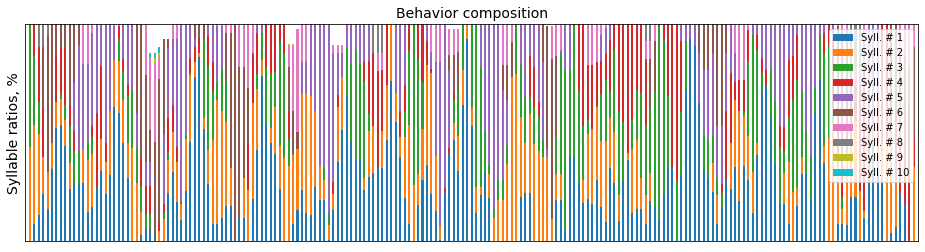

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

t1, t2 = 0, 200
idxs_to_idxs = np.where((tl[idxs_srm_tl][:, 0] > t1) & (tl[idxs_srm_tl][:, 0] < t2))[0]
idxs_sel = idxs_srm_tl[idxs_to_idxs]
bottom = np.zeros(len(idxs_sel))
for i, syl_ratio in enumerate(syl_ratio_mx[idxs_to_idxs].T):
    ax.bar(tl[idxs_sel][:, 0], syl_ratio, 0.45, bottom=bottom, label='Syll. # %s' % str(i+1))
    bottom += syl_ratio
ax.set_xlim(t1, t2)
ax.set_title('Behavior composition', fontsize=14)
ax.set_ylabel('Syllable ratios, %', fontsize=14)
ax.legend(loc='upper right')
ax.set_xticks([])
ax.set_yticks([])

## Label by unit high firing rate

In [273]:
# build unit labels
units = ['3-15', '3-16']
#units = ['8-18', '4-19']

labels = np.zeros([len(syl_ratio_mx), len(units)])
for i, unit in enumerate(units):
    act_vector = np.zeros(len(syl_ratio_mx))
    
    fr = single_units[unit][np.arange(len(syl_ratio_mx))*100]
    act_vector[fr > fr.mean() +0.51*fr.std()] = 1
    labels[:, i] = act_vector

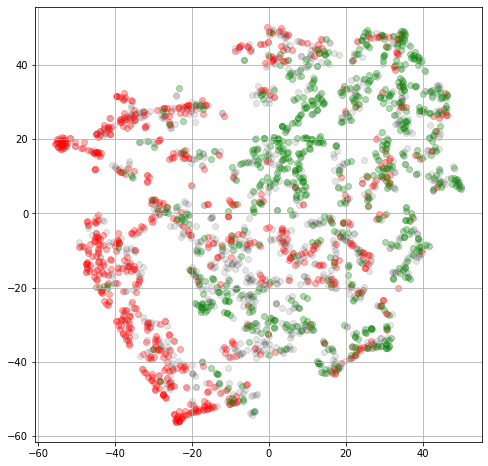

In [276]:
fit = tsne_fit

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

colors = ['red', 'green']
idxs = np.where(labels.sum(axis=1) == 0)[0]
ax.scatter(fit[idxs][:, 0], fit[idxs][:, 1], alpha=0.1, color='black')
for i, unit in enumerate(units):
    idxs = np.where(labels[:, i] > 0)[0]
    ax.scatter(fit[idxs][:, 0], fit[idxs][:, 1], alpha=0.3, color=colors[i])
    
ax.grid()
#ax.set_xlim(-5, 8)

## tSNE

In [128]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30) #, random_state=0)
tsne_res = {}

for session in selected:
    animal = session.split('_')[0]
    moseq_file = os.path.join(source, animal, session, 'moseq.h5')

    with h5py.File(moseq_file, 'r') as f:
        syl_ratio_mx = np.array(f['syl_ratio_mx'])
        idxs_srm_tl  = np.array(f['idxs_srm_tl'])
        
    tsne_res[session] = tsne.fit_transform(syl_ratio_mx)
    print('Session %s done' % session)

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Session 009266_hippoSIT_2023-04-20_08-57-39 done


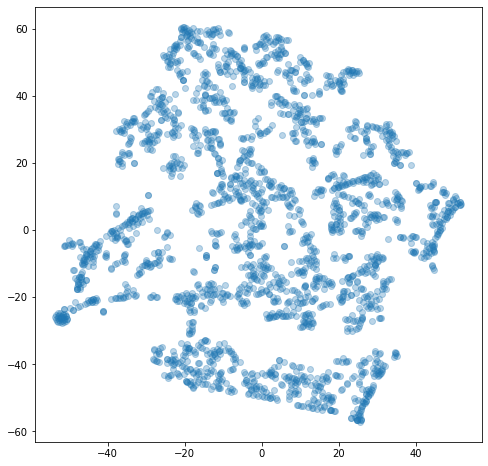

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for i, (session, tsne_fit) in enumerate(tsne_res.items()):
    ax.scatter(tsne_fit[:, 0], tsne_fit[:, 1], alpha=0.3)

## UMAP

### manually build ratio matrix 

In [1]:
from umap import UMAP

2023-11-02 16:58:15.067975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 16:58:19.712038: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-02 16:58:19.712066: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-02 16:58:19.766104: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-02 16:58:20.848939: W tensorflow/stream_executor/platform/de

### Single

In [106]:
umap_2d = UMAP(n_components=2, n_neighbors=50, min_dist=0.1) #, random_state=0, init='random')

umap_res = {}
for i in range(3):
    umap_res[i] = umap_2d.fit_transform(syl_ratio_mx)

In [134]:
tsne = TSNE(n_components=2) #, random_state=0)
tsne_res = {}

for i in range(3):
    tsne_res[i] = tsne.fit_transform(syl_ratio_mx)

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sobol

### Multiple

In [54]:
selected = sessions[7:8]
selected

['009266_hippoSIT_2023-04-20_08-57-39']

In [51]:
umap_res = {}

for session in selected:
    animal = session.split('_')[0]
    moseq_file = os.path.join(source, animal, session, 'moseq.h5')

    with h5py.File(moseq_file, 'r') as f:
        syl_ratio_mx = np.array(f['syl_ratio_mx'])
        idxs_srm_tl  = np.array(f['idxs_srm_tl'])
        
    umap_2d = UMAP(n_components=2, n_neighbors=50, min_dist=0.25) #, init='random')
    umap_res[session] = umap_2d.fit_transform(syl_ratio_mx)
    
    print('Session %s done' % session)

Session 009266_hippoSIT_2023-04-20_08-57-39 done
Session 009266_hippoSIT_2023-04-20_15-24-14 done
Session 009266_hippoSIT_2023-04-21_08-43-00 done


### Visualization

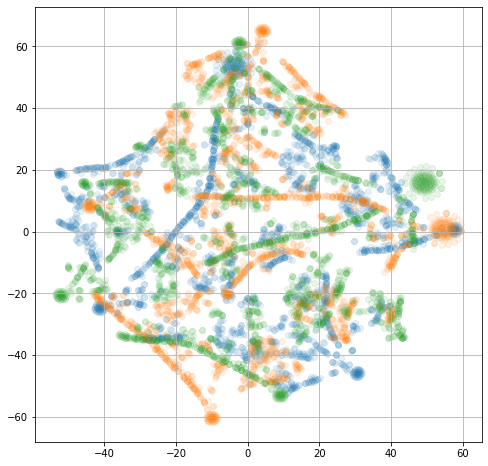

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.grid()

for i, (session, umap_fit) in enumerate(tsne_res.items()):
    #if i == 2:
    ax.scatter(umap_fit[:, 0], umap_fit[:, 1], alpha=0.1)
    #ax.set_xlim(-10, 10)

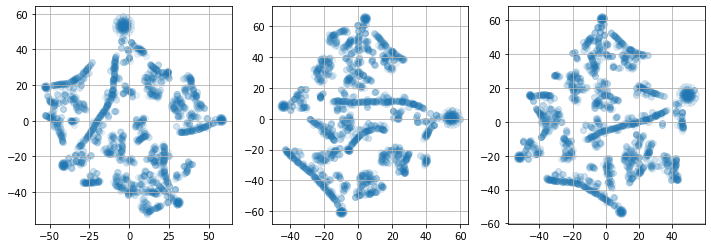

In [136]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, (session, umap_fit) in enumerate(tsne_res.items()):
    axes[i].scatter(umap_fit[:, 0], umap_fit[:, 1], alpha=0.1)
    #axes[i].set_xlim(-10, 10)
    axes[i].grid()